# Juliaで線型方程式の解の精度保証付き数値計算

$A\in \mathbb{K}^{n\times n}$ を $n$ 次行列、$b\in\mathbb{K}^n$ を $n$ 次元ベクトルとする。ただし $\mathbb{K}=\mathbb{C}$ or $\mathbb{R}$ とする。このとき、線型方程式

$$
Ax=b
$$

の解 $\tilde{x}\in\mathbb{K}$ の精度保証付き数値計算法を紹介する。
行列 $A$ が正則（$\det(A)\neq 0$）ならば、逆行列 $A^{-1}$ が存在し、線型方程式は厳密解がただ一つ存在する。したがって、精度保証付き数値計算で必要なことは、

- 行列 $A$ が正則である
- 厳密解 $\tilde{x}$ の存在する範囲を計算する（誤差評価）

の2つ。

## 区間ガウスの消去法

区間ガウスの消去法はいわゆるガウスの消去法を全て区間演算に置き換えた方法であり、"理論上は"解の厳密な包含が得られることになる。しかし、区間ガウスの消去法は、係数行列 $A$ の
次数 $n$ がある程度以上の大きくなると、解の誤差半径が爆発的に大きくなってしまい、適用不可能になるという致命的な欠点がある。これは区間演算による区間幅の増大が原因で、丸め誤差の過大評価によって計算結果が物凄く粗い評価となってしまう。例えば、`IntervalArithmetic.jl`は、区間ガウスの消去法に基づいて線型方程式の求解ができる。

In [31]:
using IntervalArithmetic
A = [2 2 3; -2 5 1; 5 6 9];
b = A*[2,2,1];　 # Exact solution: (2,2,1)^T

A = map(interval, A);
b = map(interval, b);

x = A\b
# maximum(radius.(x[:]))

3-element Array{Interval{Float64},1}:
 [1.99999, 2.00001]
 [1.99999, 2.00001]
 [0.999999, 1.00001]

解の包含の区間幅は約 $10^{-14}$ と十分小さな判官になっていると思われるが、行列のサイズ $n$ が大きくなるにつれて、区間幅が増大し、この方法は破綻する。

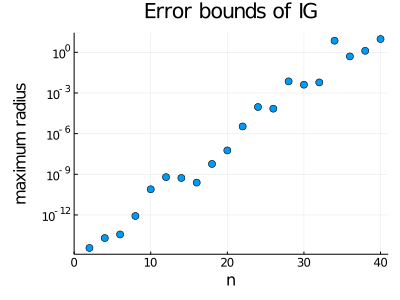

In [46]:
using Plots
index = 2:2:40;
max_rad = zeros(size(index));
i = 1;
for n ∈ index
    A = randn(n,n);
    b = A*ones(n);

    A = map(interval, A)
    b = map(interval, b)

    x = A\b
    max_rad[i] = maximum(radius.(x[:]));
    i += 1;
end
plot(index, max_rad, yscale=:log10,
    xlabel       ="n",                #X軸のラベル
    ylabel       ="maximum radius",   #Y軸のラベル
    xlims        =(0,41),             #X軸の範囲
    title="Error bounds of IG",       #タイトル
    linewidth    =2,                  #線幅
    seriestype = :scatter,            #点プロットに　
    size         =(400,300),          #プロットのサイズ
    legend = false,                   #凡例消す
)

## BLAS/LAPACKを使う高速精度保証付き数値計算法

行列 $A$ が密行列の場合の精度保証方法を紹介する。この方法の特長は行列計算単位で[区間演算を実行](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/interval_dot-mul.html)することができる。つまり BLAS や LAPACK などの高速で信頼性の高い数値計算ライブラリを利用することができる。そして、区間ガウスの消去法とは違って、次数 $n$ が数千以上のような比較的大規模な行列も計算が成功する。

In [68]:
using LinearAlgebra
n = 5000;
A = randn(n,n);
b = A*ones(n);
@time x = A\b;
# x[1:10]

  0.444968 seconds (6 allocations: 190.811 MiB, 0.39% gc time)


次の定理を使用する。

**定理**　行列 $A\in\mathbb{R}^{n\times n}$, $b\in\mathbb{R}^{n}$ に対して、線型方程式 $Ax=b$ の近似解を $\bar{x}$ とする。いま行列 $R\in\mathbb{R}^{n\times n}\approx A^{-1}$が、

$$
\|I-RA\|<1
$$

をみたすとき、

$$
\left\|A^{-1}b-\bar{x}\right\|\le\frac{\|R(b-A \bar{x})\|}{1-\|I-R A\|}
$$

が成り立つ。ただし、$I$ は $n$ 次単位行列とする。

In [79]:
norm(x,Inf),
sqrt(5000)

(1.0000000000070486, 70.71067811865476)